In [332]:
%matplotlib inline
%run utils.py
%run cell_type_nlp.py
import os.path as osp
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotnine as pn
import matplotlib.pyplot as plt
fix_jupyter_spacy_config()

In [2]:
df_pub = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstracts.csv'))
df_pub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52174 entries, 0 to 52173
Data columns (total 5 columns):
abstract    46582 non-null object
date        18497 non-null object
id          52174 non-null int64
terms       52174 non-null object
title       52172 non-null object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [3]:
df_ct = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_tcell_types.csv'))
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11524 entries, 0 to 11523
Data columns (total 6 columns):
type        11524 non-null object
count       11524 non-null int64
id          11524 non-null int64
type_key    7045 non-null object
type_lbl    7045 non-null object
type_lvl    7045 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 540.3+ KB


In [4]:
df_pr = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_proteins_resolved.csv'))
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61064 entries, 0 to 61063
Data columns (total 8 columns):
id            61064 non-null int64
start         61064 non-null int64
end           61064 non-null int64
value         61064 non-null object
class         61064 non-null object
value_norm    61064 non-null object
value_lbl     61064 non-null object
value_sym     17341 non-null object
dtypes: int64(3), object(5)
memory usage: 3.7+ MB


In [9]:
df_mg = pd.read_csv(osp.join(DATA_DIR, 'pubmed_mygene_protein_annotations.csv'))
df_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6908 entries, 0 to 6907
Data columns (total 8 columns):
id               6908 non-null object
score            6908 non-null float64
sym              6908 non-null object
name             6908 non-null object
ensemblgene      5575 non-null object
species          6908 non-null object
pr_value_norm    6908 non-null object
is_tf            6908 non-null bool
dtypes: bool(1), float64(1), object(6)
memory usage: 384.6+ KB


## Merge

In [34]:
#df_mg[df_mg['pr_value_norm'].str.contains('TET')]

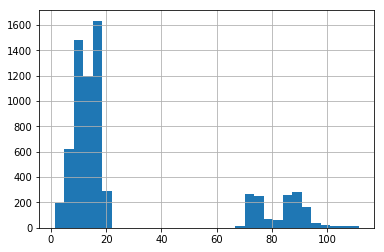

In [35]:
df_mg['score'].hist(bins=32)

In [45]:
score_threshold = 30
df_mg_tf = (
    df_mg[(df_mg['is_tf'].values == True) & (df_mg['score'] >= score_threshold)]
    # Get top hit for each term and species
    .groupby(['pr_value_norm', 'species'], group_keys=False)
    .apply(lambda g: g.sort_values('score').tail(1))
    .reset_index()
    # Group by term and summarize everything else (mostly for debugging)
    .groupby('pr_value_norm').apply(lambda g: pd.Series({
        'species': g['species'].dropna().str.cat(sep=','),
        'syms': g['sym'].str.cat(sep=','),
        'eids': g['ensemblgene'].str.cat(sep=','),
        'scores': g['score'].astype(int).astype(str).str.cat(sep=',')
    }))
    .reset_index()
    .rename(columns={'pr_value_norm': 'value_norm'})
)
assert df_mg_tf['value_norm'].is_unique
df_mg_tf.head()

,value_norm,species,syms,eids,scores
0,AHR,human,AHR,ENSG00000106546,88
1,AIRE,human,AIRE,ENSG00000160224,85
2,AR,human,AR,ENSG00000169083,85
3,ASCL2,human,ASCL2,ENSG00000183734,92
4,ASH1L,human,ASH1L,ENSG00000116539,85


In [46]:
# Get protein term mention counts per doc
df = df_pr.groupby(['id', 'value_norm']).size().rename('pr_count').reset_index()

# Add TF metadata as inner join (implicit filter to TF only proteins)
df = pd.merge(df, df_mg_tf, on='value_norm', how='inner')
assert df.groupby(['id', 'value_norm']).size().max() == 1

# Add cell types
df = pd.merge(
    df, 
    df_ct.add_prefix('ct_').rename(columns={'ct_id': 'id'})
        .groupby(['id', 'ct_type_key'])['ct_count'].sum().reset_index(),
    on='id',
    how='left'
)
assert df['ct_count'].notnull().all()

df.head()

,id,value_norm,pr_count,species,syms,eids,scores,ct_type_key,ct_count
0,6242007,CIC,1,human,CIC,ENSG00000079432,88,TH,1
1,8724834,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
2,15668741,RAG1,1,human,RAG1,ENSG00000166349,85,TREG,1
3,19502389,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
4,20208000,RAG1,3,human,RAG1,ENSG00000166349,85,TREG,1


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738 entries, 0 to 2737
Data columns (total 9 columns):
id             2738 non-null int64
value_norm     2738 non-null object
pr_count       2738 non-null int64
species        2738 non-null object
syms           2738 non-null object
eids           2738 non-null object
scores         2738 non-null object
ct_type_key    2738 non-null object
ct_count       2738 non-null int64
dtypes: int64(3), object(6)
memory usage: 213.9+ KB


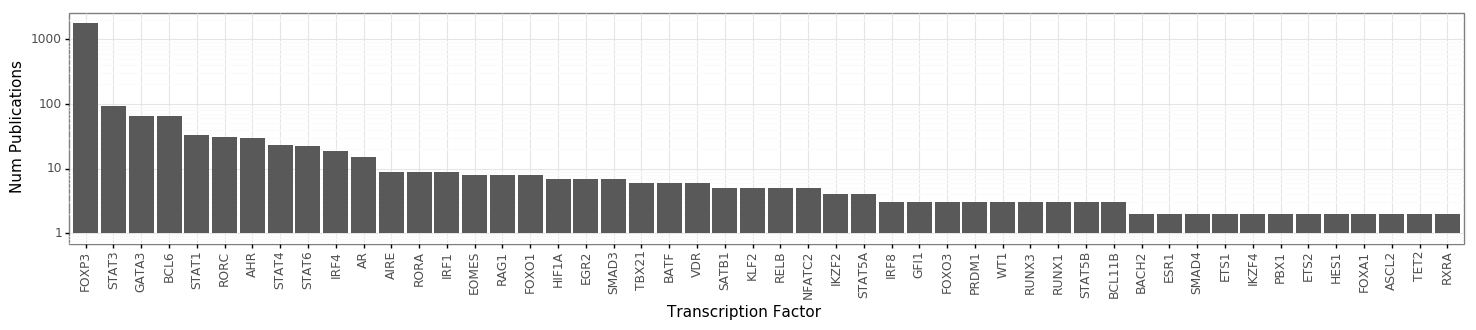

<ggplot: (-9223372036542071264)>

In [48]:
# Number of documents per TF
(
    pn.ggplot(
        df.groupby('value_norm')['id'].nunique().rename('count')
        .sort_values(ascending=False).head(50).reset_index()
        .assign(typ=lambda df: pd.Categorical(
            df['value_norm'], ordered=True,
            categories=df['value_norm'].unique()
        )),
        pn.aes(x='typ', y='count', label='count')
    ) + 
    pn.geom_bar(stat='identity') +
    pn.labs(x='Transcription Factor', y='Num Publications') +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(18, 3), axis_text_x = pn.element_text(angle = 90, hjust = .5))
)


In [49]:
df.head()

,id,value_norm,pr_count,species,syms,eids,scores,ct_type_key,ct_count
0,6242007,CIC,1,human,CIC,ENSG00000079432,88,TH,1
1,8724834,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
2,15668741,RAG1,1,human,RAG1,ENSG00000166349,85,TREG,1
3,19502389,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
4,20208000,RAG1,3,human,RAG1,ENSG00000166349,85,TREG,1


In [73]:
# sigmoid = lambda v: 1 / (1 + np.exp(-3*v + 5))
# x = np.linspace(-2, 10, 100)
# plt.plot(x, sigmoid(x))
# print(sigmoid(0))
# print(sigmoid(1))
# print(sigmoid(2))

In [119]:
df_score = (
    df.groupby(['ct_type_key', 'value_norm'])
        .agg({'pr_count': 'sum', 'id': 'nunique'})
        .rename(columns={'id': 'pr_ct_nuniq_pub'})
        .reset_index()
)
df_score = pd.merge(
    df_score, 
    df.groupby(['value_norm'])
        .agg({'id': 'nunique', 'ct_type_key': 'nunique'})
        .rename(columns={'id': 'pr_nuniq_pub', 'ct_type_key': 'pr_nuniq_ct'})
        .reset_index(),
    on='value_norm'
)
df_score = pd.merge(
    df_score, 
    df.groupby(['ct_type_key'])
        .agg({'id': 'nunique', 'value_norm': 'nunique'})
        .rename(columns={'id': 'ct_nuniq_pub', 'value_norm': 'ct_nuniq_pr'}),
    on='ct_type_key'
)

assert df.groupby(['value_norm'])['eids'].nunique().max() == 1
df_score['ensembl_id'] = df_score['value_norm'].map(dict(zip(df['value_norm'], df['eids'])))
assert df_score['ensembl_id'].notnull().all()

df_score['score'] = df_score['pr_count'].apply(np.sqrt) / df_score['pr_nuniq_ct']
#df_score['score'] = df_score['pr_ct_nuniq_pub'].apply(lambda v: 1 if v >= 2 else ) * (df_score['pr_count'].apply(np.sqrt) / df_score['pr_nuniq_ct'])
# df_score['score'] = (
#     (df_score['pr_ct_nuniq_pub'] / df_score['ct_nuniq_pub']) / 
#     (df_score['pr_nuniq_ct'] / df_score['ct_type_key'].nunique())
# )

df_score = (
    df_score.groupby(['ct_type_key'], group_keys=False)
    .apply(lambda g: 
           g.sort_values('score', ascending=False)
           .assign(rank=np.arange(len(g))+1, score_norm=lambda dg: dg['score']/dg['score'].sum())
    )
)

df_score.head()

,ct_type_key,value_norm,pr_count,pr_ct_nuniq_pub,pr_nuniq_pub,pr_nuniq_ct,ct_nuniq_pub,ct_nuniq_pr,ensembl_id,score,rank,score_norm
3,MAIT,ZBTB16,2,1,1,2,5,4,ENSG00000109906,0.707107,1,0.688304
0,MAIT,EOMES,3,2,8,8,5,4,ENSG00000163508,0.216506,2,0.210749
2,MAIT,STAT3,1,1,92,15,5,4,ENSG00000168610,0.066667,3,0.064894
1,MAIT,FOXP3,1,1,1779,27,5,4,ENSG00000049768,0.037037,4,0.036052
7,NKT,ZBTB16,2,1,1,2,19,7,ENSG00000109906,0.707107,1,0.280415


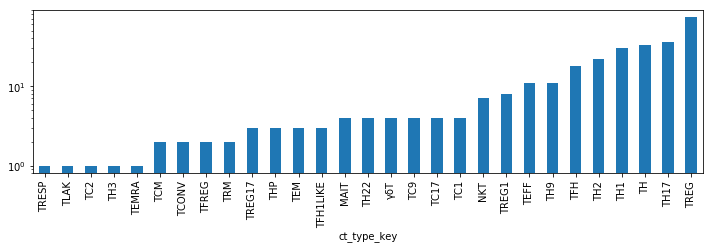

In [120]:
ax = df_score.groupby('ct_type_key')['value_norm'].nunique().sort_values().plot(kind='bar', figsize=(12, 3))
ax.set_yscale('log')

In [81]:
# (
#     df_score[df_score['rank'] <= 15]
#         .assign(pr_nuniq_pub=lambda df: pd.cut(df['pr_nuniq_pub'], bins=[0, 1, 10, 50, np.inf]))
#         .assign(pr_ct_nuniq_pub=lambda df: pd.cut(df['pr_ct_nuniq_pub'], bins=[0, 1, 3, 10, np.inf]))
#         .assign(cell_type=lambda df: pd.Categorical(
#             df['ct_type_key'], ordered=True,
#             categories=df['ct_type_key'].value_counts().sort_values().index
#         ))
#         .pivot(index='cell_type', columns='rank', values='value_norm')
# )

## Ranking Visualization

In [100]:
ct_ignore = ['TCONV', 'TLAK', 'TRESP']

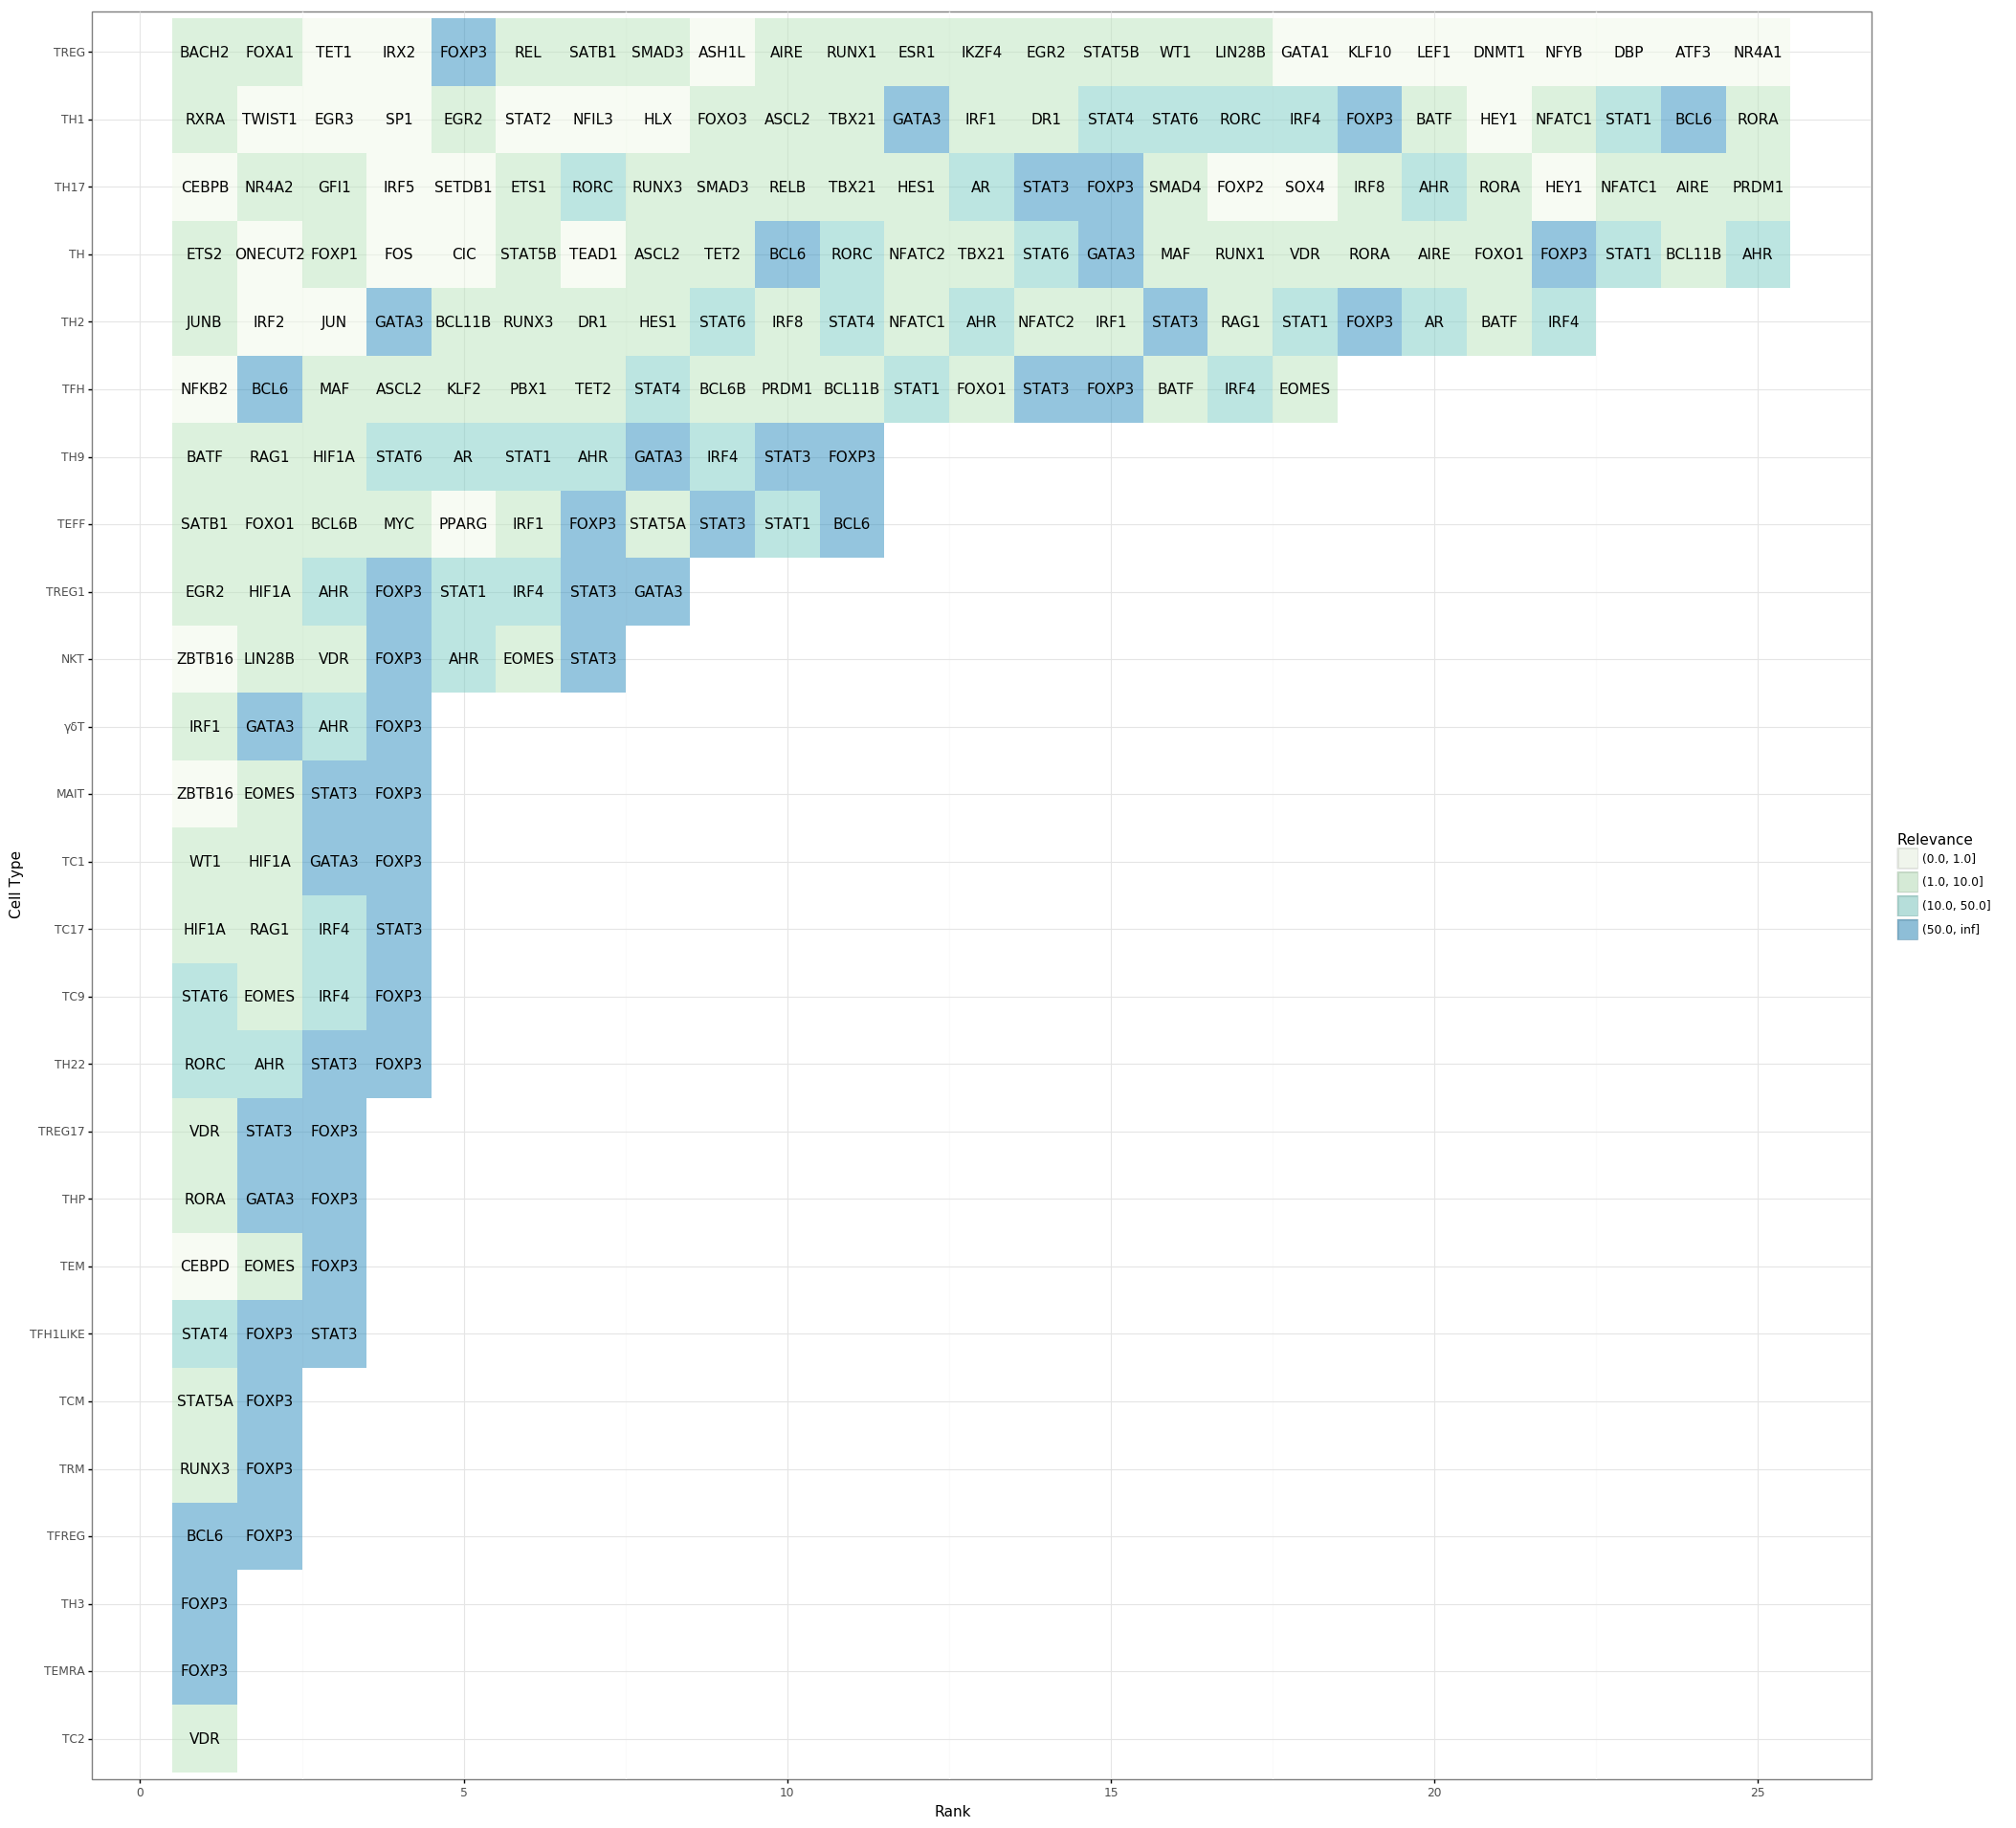

<ggplot: (-9223372036532865469)>

In [101]:
(
    pn.ggplot(
        df_score[(df_score['rank'] <= 25) & (~df_score['ct_type_key'].isin(ct_ignore))]
        .assign(pr_nuniq_pub=lambda df: pd.cut(df['pr_nuniq_pub'], bins=[0, 1, 10, 50, np.inf]))
        .assign(pr_ct_nuniq_pub=lambda df: pd.cut(df['pr_ct_nuniq_pub'], bins=[0, 1, 3, 10, np.inf]))
        .assign(cell_type=lambda df: pd.Categorical(
            df['ct_type_key'], ordered=True,
            categories=df['ct_type_key'].value_counts().sort_values().index
        )),
        pn.aes(y='cell_type', x='rank', label='value_norm', fill='pr_nuniq_pub')
    ) + 
    pn.geom_tile(alpha=.5) + 
    #pn.scale_fill_cmap_d('Blues') +
    pn.scale_fill_brewer(palette='GnBu') +
    #pn.scale_size_discrete(range=(10, 14)) +
    pn.geom_text(color='black', alpha=1) + 
    pn.labs(fill='Relevance', x='Rank', y='Cell Type') +
    pn.theme_bw() +
    pn.theme(figure_size=(24, 24)) 
)

In [102]:
df['value_norm'].nunique()

97

In [103]:
df['value_norm'].sort_values().unique()

array(['AHR', 'AIRE', 'AR', 'ASCL2', 'ASH1L', 'ATF3', 'BACH2', 'BATF',
       'BCL11B', 'BCL6', 'BCL6B', 'CEBPB', 'CEBPD', 'CIC', 'DBP', 'DNMT1',
       'DR1', 'EGR2', 'EGR3', 'EOMES', 'ESR1', 'ETS1', 'ETS2', 'FOS',
       'FOXA1', 'FOXO1', 'FOXO3', 'FOXP1', 'FOXP2', 'FOXP3', 'GATA1',
       'GATA3', 'GFI1', 'GLI1', 'HES1', 'HEY1', 'HIF1A', 'HLX', 'IKZF2',
       'IKZF4', 'IRF1', 'IRF2', 'IRF4', 'IRF5', 'IRF8', 'IRX2', 'JUN',
       'JUNB', 'KLF10', 'KLF2', 'LEF1', 'LIN28B', 'MAF', 'MYC', 'NFATC1',
       'NFATC2', 'NFIL3', 'NFKB2', 'NFYB', 'NR4A1', 'NR4A2', 'NR4A3',
       'ONECUT2', 'PBX1', 'PPARG', 'PRDM1', 'RAG1', 'REL', 'RELB', 'RORA',
       'RORC', 'RUNX1', 'RUNX3', 'RXRA', 'SATB1', 'SETDB1', 'SMAD1',
       'SMAD3', 'SMAD4', 'SOX4', 'SP1', 'STAT1', 'STAT2', 'STAT3',
       'STAT4', 'STAT5A', 'STAT5B', 'STAT6', 'TBX21', 'TEAD1', 'TET1',
       'TET2', 'TWIST1', 'VDR', 'WT1', 'XBP1', 'ZBTB16'], dtype=object)

In [106]:
pr = 'VDR'
df_score[df_score['value_norm'] == pr]

,ct_type_key,value_norm,pr_count,pr_ct_nuniq_pub,pr_nuniq_pub,pr_nuniq_ct,ct_nuniq_pub,ct_nuniq_pr,score,rank,score_norm
10,NKT,VDR,3,1,6,5,19,7,0.346410,3,0.137375
297,TC2,VDR,3,1,6,5,1,1,0.346410,1,1.000000
40,TH,VDR,6,2,6,5,100,33,0.489898,18,0.026642
110,TREG,VDR,5,1,6,5,1714,73,0.447214,66,0.006422
285,TREG17,VDR,2,1,6,5,10,3,0.282843,1,0.456527


In [107]:
df[df['value_norm'] == pr]

,id,value_norm,pr_count,species,syms,eids,scores,ct_type_key,ct_count
2590,21114675,VDR,3,human,VDR,ENSG00000111424,86,NKT,1
2591,25201466,VDR,1,human,VDR,ENSG00000111424,86,TH,1
2592,25576905,VDR,5,human,VDR,ENSG00000111424,86,TH,2
2593,26750596,VDR,3,human,VDR,ENSG00000111424,86,TC2,1
2594,27614264,VDR,5,human,VDR,ENSG00000111424,86,TREG,1
2595,28926770,VDR,2,human,VDR,ENSG00000111424,86,TREG17,1


In [205]:
#df_pub[df_pub['id'].isin(df[df['value_norm'] == pr]['id'])][['id', 'abstract']]

In [108]:
#df_pub[df_pub['id'].isin(df[df['value_norm'] == pr]['id'])][['id', 'abstract']].iloc[1]['abstract']
df_pub[df_pub['id'] == 21114675].iloc[0]['abstract']

'Vitamin D is an important regulator of immune function. T cells express the vitamin D receptor (VDR) and have been shown to be direct and indirect vitamin D targets. Why should T cells be responsive to vitamin D? The data suggest that expression of the VDR is required for the development of two cell types, NKT cells and CD8αα T cells, which inhibit autoimmunity. In addition, effector T cell cytokine production is regulated by vitamin D. Available evidence suggests that NKT and CD8αα T cells express the VDR as part of the selection process to protect against the generation of autoimmunity, particularly in the gut.'

In [89]:
tag_tcell_types('metabolism, as well as the effects of metabolism and its products on the immune response, is still limited. We report that a metabolic program controlled by the transcription factors hypoxia inducible factor-1α (HIF1-α) and aryl hydrocarbon receptor (AHR) supports the differentiation of type 1 regulatory T cell (Tr1) cells. HIF1-α controls the early metabolic reprograming of Tr1 cells. At later time points, AHR promotes HIF1-α degradation and takes control of Tr1 cell metabolism. Extracellular ATP (eATP) and hypoxia, linked to inflammation, trigger AHR inactivation by HIF1-α and inhibit Tr1 cell ', details=True)

,type,offset,len
0,TR1,314,3


A few good hits:
```
ZBTB16 | 23223428 | MAIT/NKT | Knockdown of the transcription factor PLZF/ZBTB-16, which is involved in the effector program of iNKT cells, diminishes their proapoptotic phenotype. Conversely, overexpression of PLZF/ZBTB-16 in conventional T cells leads to a proapoptotic phenotype.
STAT6 | 23254356 | TC9 | Similarly to the CD4(+) counterpart, Tc9 cells required for their differentiation STAT6 and IRF4.
HIF1α | 26005855 | TREG1 | We report that a metabolic program controlled by the transcription factors hypoxia inducible factor-1α (HIF1-α) and aryl hydrocarbon receptor (AHR) supports the differentiation of type 1 regulatory T cell (Tr1) cells.
```

## Text Visualization

In [145]:
from spacy import displacy
def get_text_viz(text, ents, title=None):
    doc = {'text': text, 'ents': ents, 'title': title}
    colors = {'TYPE': '#09a3d5', 'PROTEIN': '#05b083'}
    options = {'ents': ['TYPE', 'PROTEIN'], 'colors': colors}
    html = displacy.render(doc, style='ent', manual=True, options=options)
    return html

In [349]:
def get_example_pubs(cell_type, protein, limit=10):
    ids = np.intersect1d(df_ct[df_ct['type_key'] == cell_type]['id'], df_pr[df_pr['value_norm'] == protein]['id'])
    ids = set(ids)
    
    df_pubs = df_pub[df_pub['id'].isin(ids)].copy().sort_values('date', ascending=False)
    df_pubs['text'] = df_pubs.apply(lambda r: r['title'] + '\n' + r['abstract'], axis=1)
    res = []
    for i, r in df_pubs.iterrows():
        if len(res) >= limit:
            break
        df_ct_tag = tag_tcell_types(r['text'], details=True)
        df_ct_tag = df_ct_tag[df_ct_tag['type'] == cell_type]
        df_ct_tag['start'] = df_ct_tag['offset']
        df_ct_tag['end'] = df_ct_tag['start'] + df_ct_tag['len']
        
        df_pr_tag = df_pr[df_pr['id'] == r['id']]
        df_pr_tag = df_pr_tag[df_pr_tag['value_norm'] == protein]
        if len(df_ct_tag) > 0 and len(df_pr_tag) > 0:
            df_ent = pd.concat([
                df_pr_tag[['start', 'end']].assign(label='PROTEIN'),
                df_ct_tag[['start', 'end']].assign(label='TYPE')
            ]).sort_values('start')
            div = get_text_viz(
                prep(r['text']), 
                df_ent.to_dict(orient='records'),
                #title=r['title']
            )
            div = re.sub(r'(<div[^>]*>)', '\\1<h3>', div, count=1)
            div = re.sub(r'</br>', '</h3></br>', div, count=1)
            res.append({'html': div, 'id': r['id']})
    return pd.DataFrame(res)

In [350]:
# from IPython.core.display import display, HTML
# #docs = get_example_text('THP', 'RORA', limit=10)
# #df_pub_samp = get_example_pubs('TH1', 'RXRA', limit=10)
# df_pub_samp = get_example_pubs('TH', 'VDR', limit=10)
# html = '\n'.join(df_pub_samp['html'].values)
# display(HTML(html))

In [351]:
#df_pub_samp['html'].iloc[0]

In [372]:
df_score.head()

,ct_type_key,value_norm,pr_count,pr_ct_nuniq_pub,pr_nuniq_pub,pr_nuniq_ct,ct_nuniq_pub,ct_nuniq_pr,ensembl_id,score,rank,score_norm
3,MAIT,ZBTB16,2,1,1,2,5,4,ENSG00000109906,0.707107,1,0.688304
0,MAIT,EOMES,3,2,8,8,5,4,ENSG00000163508,0.216506,2,0.210749
2,MAIT,STAT3,1,1,92,15,5,4,ENSG00000168610,0.066667,3,0.064894
1,MAIT,FOXP3,1,1,1779,27,5,4,ENSG00000049768,0.037037,4,0.036052
7,NKT,ZBTB16,2,1,1,2,19,7,ENSG00000109906,0.707107,1,0.280415


In [375]:
def get_summary(g):
    pr = g['value_norm'].iloc[0]
    g = g.sort_values('pr_ct_nuniq_pub', ascending=False)
    df_pubs = [(ct, get_example_pubs(ct, pr, limit=10).assign(cell_type=ct)) for ct in g['ct_type_key'].values]
    return pd.Series({
        'n_unique_pubs': g['pr_nuniq_pub'].iloc[0],
        'n_unique_pubs_by_type': g['ct_type_key'].str.cat(g['pr_ct_nuniq_pub'].astype(str), sep=':').str.cat(sep=', '),
        'score': g['score_norm'].max(),
        'ensembl_id': g['ensembl_id'].iloc[0],
        'pub_samp': df_pubs
    })
    
assert df_score.groupby(['ct_type_key', 'value_norm']).size().max() == 1
assert df_score.groupby('value_norm')['pr_nuniq_pub'].nunique().max() == 1
df_summary = df_score[~df_score['ct_type_key'].isin(ct_ignore)]\
    .groupby('value_norm').apply(get_summary)\
    .sort_values('score', ascending=False)\
    .reset_index().copy()

In [378]:
df_summary.head(1)

,value_norm,n_unique_pubs,n_unique_pubs_by_type,score,ensembl_id,pub_samp
0,VDR,6,"TH:2, NKT:1, TC2:1, TREG:1, TREG17:1",1.0,ENSG00000111424,"[(TH, [html, id]), (NKT, [html]), (TC2, [html]), (TREG, [html]), (TREG17, [])]"


In [387]:
def get_collapsible_details(r):
    tag = '<details><summary>Subtypes</summary>'
    for ct, df in r['pub_samp']:
        if len(df) == 0:
            continue
        entry = ''.join([
            '<a href="https://www.ncbi.nlm.nih.gov/pubmed/{}">{}</a>{}'.format(rr['id'], rr['id'], rr['html'])
            for _, rr in df.iterrows()
        ])
        tag += '<details><summary>{}</summary>{}</details>'.format(ct, entry)
    return tag + '</details>'
        
df_summary['details'] = df_summary.apply(get_collapsible_details, axis=1)

In [388]:
df_exp = df_summary.drop('pub_samp', axis=1).rename(columns={
    'value_norm': 'transcription_factor',
    'details': 'abstracts'
})

In [390]:
pd.set_option('display.max_colwidth', -1)
html = df_exp.to_html(classes='wide', escape=False).replace('\\n', '')
html = create_table_doc(html)
path = osp.join(DATA_DIR, 'transcription_factor_rankings.html')
with open(path, 'w') as fd:
    fd.write(html)
path

'data/transcription_factor_rankings.html'

In [393]:
path = osp.join(DATA_DIR, 'transcription_factor_rankings.csv')
df_exp.drop('abstracts', axis=1).to_csv(path, index=False)
path

'data/transcription_factor_rankings.csv'